In [160]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import unittest

# Data versioning

* Se utilizan herramientas de versionado de datos para mantener un registro de cambios y versiones de los conjuntos de datos utilizados.

* **Los archivos son versionados mediante DVC y se ubican en las carpetas raw y preprocessed**

* **Se genera un almacenamiento remoto local en /data/dvc_storage/**

In [186]:
def import_rawdata():
    # fetch dataset 
    regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 

    # create dataframes (features, targets, variables, raw_df)

    features = regensburg_pediatric_appendicitis.data.features 
    targets = regensburg_pediatric_appendicitis.data.targets 
    raw_df = pd.concat([features,targets], axis = 1)
    variables = regensburg_pediatric_appendicitis.variables

    print("Data imported succesfully")
    return {
         'raw_data':raw_df 
        ,'features': features
        ,'targets': targets
        ,'variables': variables
    }   

def save_rawdata(imported_data):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    path = os.path.join(parent_directory,'data/raw/uci_df_raw.csv')
    imported_data.to_csv(path)

    print("Data stored at:", path)
    return None

In [163]:
# fetch dataset 
df = import_rawdata()['raw_data']
df = df[df['Diagnosis'].notna()]
  
# data (as pandas dataframes) 
X = df.drop(['Management','Severity','Diagnosis'], axis=1)
y = df['Diagnosis'].map({'appendicitis':1,'no appendicitis': 0 })

Data imported succesfully


## EDA

In [164]:
def generate_descriptive_stats(df):
    """
    Generate descriptive statistics for numerical columns
    """
    print("\n=== Descriptive Statistics ===")
    print(df.describe())
    
    # Additional statistics for numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        print(f"\nDetailed statistics for {col}:")
        print(f"Skewness: {df[col].skew():.2f}")
        print(f"Kurtosis: {df[col].kurtosis():.2f}")
        
def create_visualizations(df):
    """
    Create various visualizations for the dataset
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Distribution plots for numerical variables
    plt.figure(figsize=(15, 5*len(numerical_cols)))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols), 2, 2*i-1)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        
        plt.subplot(len(numerical_cols), 2, 2*i)
        sns.boxplot(data=df, y=col)
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Bar plots for categorical variables
    if len(categorical_cols) > 0:
        plt.figure(figsize=(12, 5*len(categorical_cols)))
        for i, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 1, i)
            sns.countplot(data=df, x=col)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [165]:
# Generate descriptive statistics
generate_descriptive_stats(X)


=== Descriptive Statistics ===
              Age         BMI      Height      Weight  Length_of_Stay  \
count  780.000000  754.000000  755.000000  778.000000      777.000000   
mean    11.341831   18.905138  147.997616   43.158625        4.285714   
std      3.529811    4.387940   19.737546   17.397830        2.575302   
min      0.000000    7.830000   53.000000    3.960000        1.000000   
25%      9.197500   15.722500  137.000000   29.500000        3.000000   
50%     11.440000   18.045000  149.500000   41.300000        3.000000   
75%     14.040000   21.185000  163.000000   54.000000        5.000000   
max     18.360000   38.160000  192.000000  103.000000       28.000000   

       Alvarado_Score  Paedriatic_Appendicitis_Score  Appendix_Diameter  \
count      730.000000                     730.000000         498.000000   
mean         5.921918                       5.253425           7.762651   
std          2.155972                       1.958456           2.536671   
min       

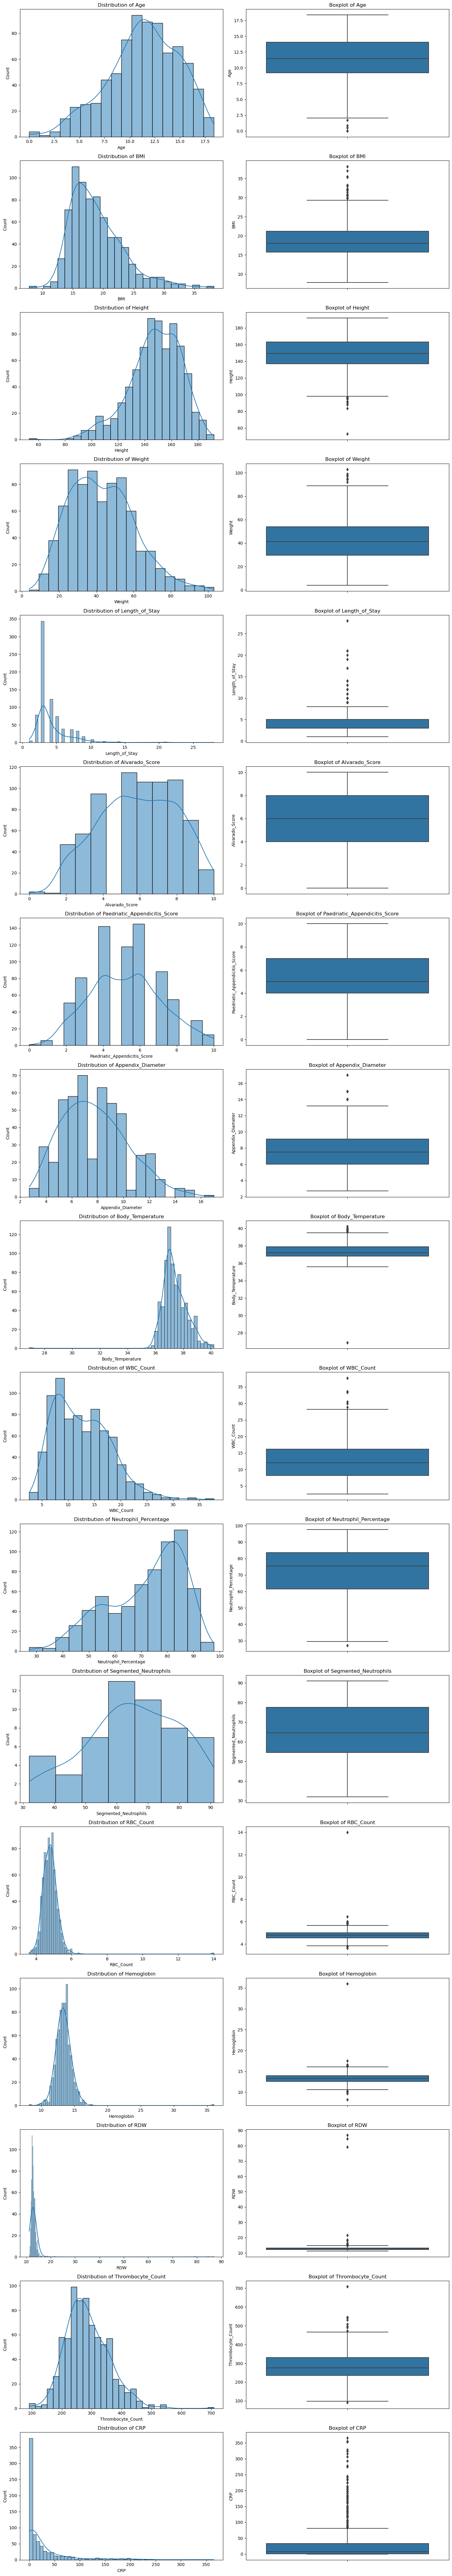

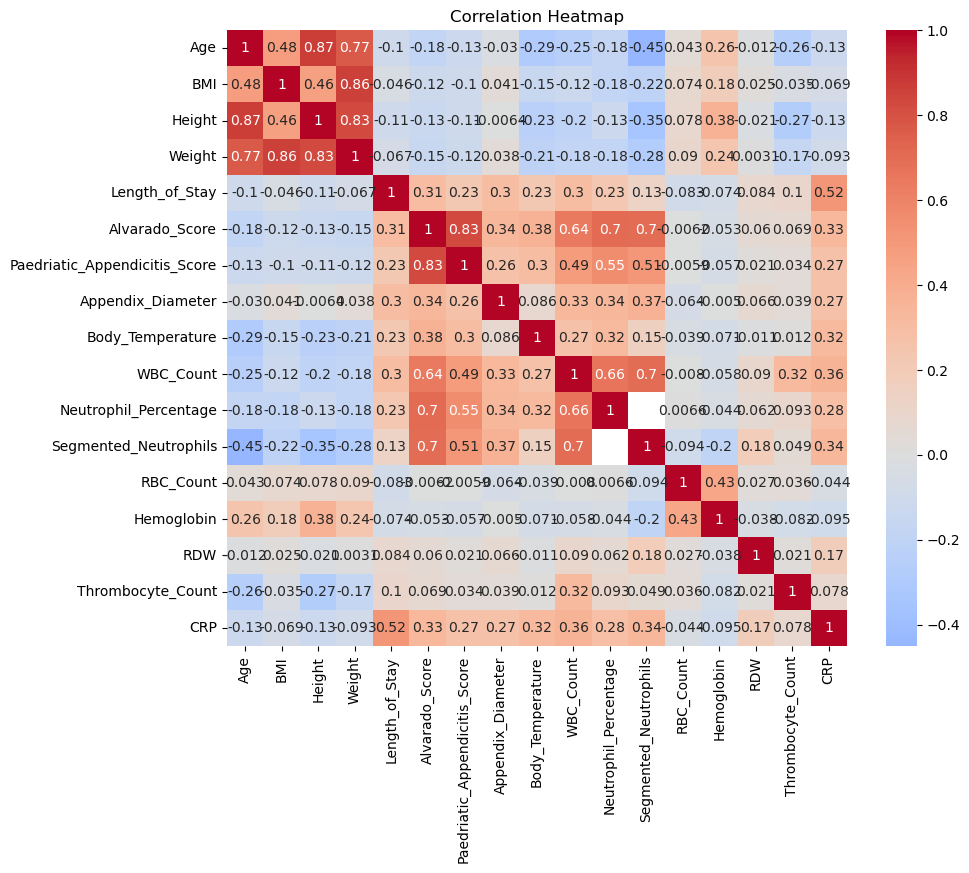

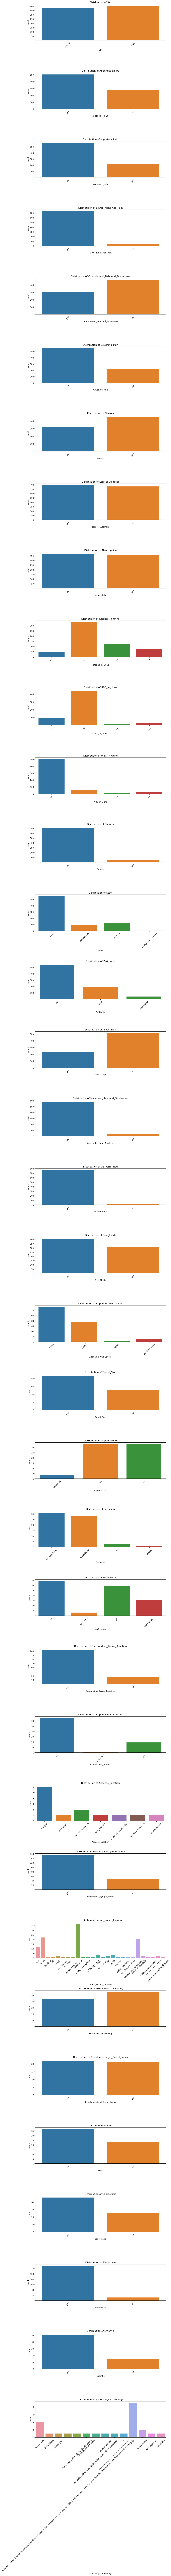

In [172]:
create_visualizations(X)

# Documentación de la Clase `DataPreprocessor`

La clase `DataPreprocessor` proporciona herramientas de preprocesamiento para datos antes de su uso en un modelo de aprendizaje automático. Esta clase permite manejar variables numéricas y categóricas, así como reducir la dimensionalidad de los datos si se especifica. A continuación, se detallan los métodos principales de la clase y su funcionalidad:

### 1. `__init__`
Inicializa el preprocesador con los siguientes parámetros:
   - `normalization_method`: Método de normalización para variables numéricas, que puede ser `'standard'` (estandarización) o `'minmax'` (normalización de valores a [0, 1]).
   - `categorical_method`: Método de codificación para variables categóricas, que puede ser `'label'` (codificación con etiquetas) o `'onehot'` (codificación binaria).
   - `reduce_dimensions`: Booleano que indica si se aplicará reducción de dimensionalidad con PCA.
   - `n_components`: Número de componentes principales para PCA, puede ser un número entero o `None`, en cuyo caso se determina automáticamente.
   - `random_state`: Semilla para resultados reproducibles.

### 2. `identify_column_types(df)`
Identifica las columnas numéricas y categóricas en el DataFrame `df` y las almacena en `self.numerical_columns` y `self.categorical_columns`:
   - Las columnas numéricas se detectan como aquellas con tipos `int64` o `float64`.
   - Las columnas categóricas se detectan como aquellas con tipos `object` o `category`.

### 3. `create_preprocessors`
Crea los transformadores para el preprocesamiento basado en los métodos especificados:
   - **Numerical Transformer**: Aplica estandarización (`StandardScaler`) o normalización (`MinMaxScaler`) para variables numéricas.
   - **Categorical Transformer**: Aplica `LabelEncoder` o `OneHotEncoder` para variables categóricas, dependiendo del método especificado.

### 4. `fit_transform(df)`
Aplica el preprocesamiento a los datos en `df` y devuelve un DataFrame transformado:
   - Llama a `identify_column_types` para identificar los tipos de columna y a `create_preprocessors` para crear los transformadores necesarios.
   - **Procesamiento de datos numéricos**: Imputa valores nulos con la media y aplica el método de normalización o estandarización.
   - **Procesamiento de datos categóricos**: Aplica codificación de etiquetas o `OneHotEncoder`. Cada columna se procesa individualmente si se usa `LabelEncoder`, o en conjunto si se usa `OneHotEncoder`.
   - **Reducción de Dimensionalidad**: Si `reduce_dimensions` es `True`, aplica PCA a los datos procesados y reduce el número de características a `n_components`.
   - **Combina los datos**: Devuelve el DataFrame con los datos procesados y, si se aplica PCA, el DataFrame con las componentes principales.

### 5. `plot_explained_variance`
Muestra un gráfico de la varianza explicada acumulada en función del número de componentes principales cuando se aplica PCA:
   - **Gráfico de varianza explicada**: Muestra cuánta varianza acumulada captura cada componente principal.
   - **Detalles de varianza**: Imprime la proporción de varianza explicada por cada componente, lo que ayuda a entender el impacto de la reducción de dimensionalidad en la variabilidad de los datos.

### Uso
La clase `DataPreprocessor` permite un flujo de trabajo eficiente de preprocesamiento, desde la imputación de valores hasta la reducción de dimensionalidad. Está diseñada para ser flexible y modular, permitiendo diferentes métodos de normalización, codificación y reducción de dimensiones.

### Ejemplo de uso
```python
# Instanciar y aplicar el preprocesador
preprocessor = DataPreprocessor(normalization_method='minmax', categorical_method='onehot', reduce_dimensions=True, n_components=5)
processed_data = preprocessor.fit_transform(df)


In [173]:
class DataPreprocessor:
    def __init__(self, normalization_method='standard', categorical_method='onehot', 
                 reduce_dimensions=True, n_components=None, random_state=42):
        """
        Initialize the preprocessor with specified methods
        
        Parameters:
        - normalization_method: 'standard' or 'minmax'
        - categorical_method: 'label' or 'onehot'
        - reduce_dimensions: boolean, whether to apply PCA
        - n_components: int or float, number of components for PCA
        """
        self.normalization_method = normalization_method
        self.categorical_method = categorical_method
        self.reduce_dimensions = reduce_dimensions
        self.n_components = n_components
        self.random_state = random_state
        
        # Initialize transformers as dictionaries to store one transformer per column
        self.numerical_transformer = None
        self.categorical_transformers = {}
        self.pca = None
        
        # Store column information
        self.numerical_columns = None
        self.categorical_columns = None
        
    def identify_column_types(self, df):
        """Identify numerical and categorical columns"""
        self.numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
        self.categorical_columns = df.select_dtypes(include=['object', 'category']).columns
        
        print("Numerical columns:", list(self.numerical_columns))
        print("Categorical columns:", list(self.categorical_columns))
                    
    def create_preprocessors(self):
        """Create preprocessing transformers based on specified methods"""
        # Numerical preprocessing
        if self.normalization_method == 'standard':
            self.numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
        else:  # minmax
            self.numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', MinMaxScaler())
            ])

        # Categorical preprocessing
        if self.categorical_method == 'onehot':
            self.categorical_transformers['onehot'] = OneHotEncoder(
                drop='first', sparse_output=False, handle_unknown='ignore'
            )
    
    def fit_transform(self, df):
        """Fit and transform the data"""
        # Identify column types
        self.identify_column_types(df)
        
        # Create preprocessors
        self.create_preprocessors()
        
        # Process numerical data
        numerical_data = None
        if len(self.numerical_columns) > 0:
            numerical_data = self.numerical_transformer.fit_transform(df[self.numerical_columns])
            numerical_data = pd.DataFrame(numerical_data, 
                                        columns=self.numerical_columns,
                                        index=df.index)
        
        # Process categorical data
        categorical_data = None
        if len(self.categorical_columns) > 0:
            if self.categorical_method == 'label':
                categorical_data = pd.DataFrame(index=df.index)
                for col in self.categorical_columns:
                    # Create a new LabelEncoder for each column
                    le = LabelEncoder()
                    # Handle missing values before encoding
                    col_data = df[col].fillna('missing')
                    categorical_data[col] = le.fit_transform(col_data)
                    self.categorical_transformers[col] = le
            else:  # onehot
                # Create and fit OneHotEncoder
                onehot = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
                # Handle missing values before encoding
                categorical_matrix = df[self.categorical_columns].fillna('missing')
                categorical_data = onehot.fit_transform(categorical_matrix)
                # Get feature names after one-hot encoding
                feature_names = onehot.get_feature_names_out(self.categorical_columns)
                categorical_data = pd.DataFrame(categorical_data, 
                                             columns=feature_names,
                                             index=df.index)
                self.categorical_transformers['onehot'] = onehot
        
        # Combine processed data
        processed_data = pd.concat([numerical_data, categorical_data], axis=1)
        
        # Apply dimension reduction if specified
        if self.reduce_dimensions:
            if self.n_components is None:
                self.n_components = min(len(processed_data.columns), len(processed_data))
            
            self.pca = PCA(n_components=self.n_components, random_state=self.random_state)
            reduced_data = self.pca.fit_transform(processed_data)
            
            # Create DataFrame with PCA components
            columns = [f'PC{i+1}' for i in range(reduced_data.shape[1])]
            processed_data = pd.DataFrame(reduced_data, 
                                        columns=columns,
                                        index=df.index)
            
            # Plot explained variance ratio
            self.plot_explained_variance()
        
        return processed_data
    
    def plot_explained_variance(self):
        """Plot the explained variance ratio for PCA components"""
        if self.pca is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(self.pca.explained_variance_ratio_) + 1),
                    np.cumsum(self.pca.explained_variance_ratio_), 'bo-')
            plt.xlabel('Number of Components')
            plt.ylabel('Cumulative Explained Variance Ratio')
            plt.title('Explained Variance Ratio vs Number of Components')
            plt.grid(True)
            plt.show()
            
            # Print explained variance ratio
            print("\nExplained variance ratio by component:")
            for i, ratio in enumerate(self.pca.explained_variance_ratio_):
                print(f"PC{i+1}: {ratio:.4f}")

Numerical columns: ['Age', 'BMI', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_Diameter', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP']
Categorical columns: ['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings']


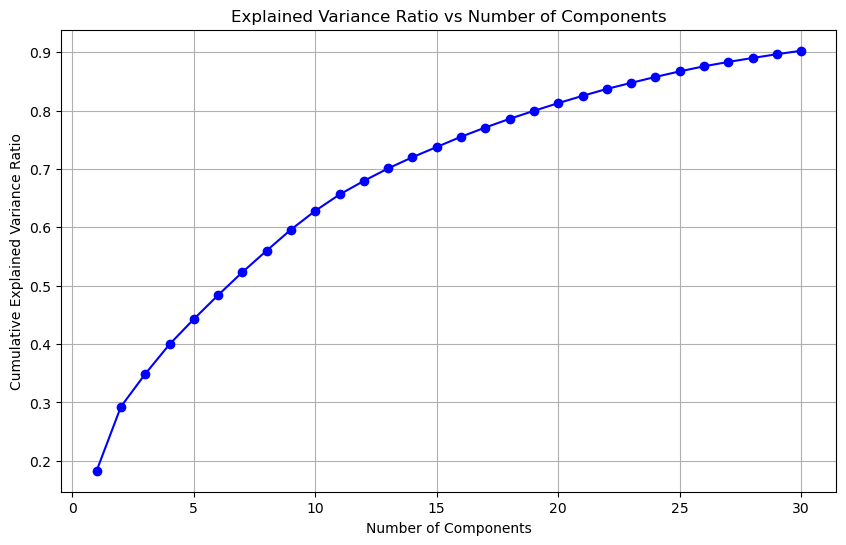


Explained variance ratio by component:
PC1: 0.1831
PC2: 0.1098
PC3: 0.0560
PC4: 0.0508
PC5: 0.0432
PC6: 0.0411
PC7: 0.0394
PC8: 0.0369
PC9: 0.0361
PC10: 0.0321
PC11: 0.0280
PC12: 0.0233
PC13: 0.0214
PC14: 0.0192
PC15: 0.0176
PC16: 0.0175
PC17: 0.0158
PC18: 0.0149
PC19: 0.0137
PC20: 0.0131
PC21: 0.0125
PC22: 0.0119
PC23: 0.0104
PC24: 0.0101
PC25: 0.0096
PC26: 0.0087
PC27: 0.0075
PC28: 0.0068
PC29: 0.0064
PC30: 0.0060


In [174]:
# Create preprocessor
preprocessor = DataPreprocessor(
    normalization_method='standard',  # or 'minmax'
    categorical_method='onehot',      # or 'label'
    reduce_dimensions=True,
    n_components=0.90                 # Keep components explaining 90% of variance
)

# Fit and transform data
processed_data = preprocessor.fit_transform(X)

# Documentación de la Clase `MLPipeline`

La clase `MLPipeline` es una implementación de un pipeline de aprendizaje automático que permite la creación, evaluación, ajuste y comparación de varios modelos. A continuación, se describen los métodos principales de la clase y su funcionalidad.

### 1. `__init__`
Inicializa el pipeline con los siguientes componentes:
   - `random_state`: Semilla para obtener resultados reproducibles en los modelos que lo permiten.
   - `models`: Un diccionario que contiene cinco modelos (`LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, `SVC`, y `KNeighborsClassifier`), cada uno con su configuración de parámetros para ajuste por `GridSearchCV`.
   - `best_models`: Diccionario vacío donde se almacenarán los mejores modelos después de realizar el ajuste de hiperparámetros.

### 2. `split_data(X, y, test_size=0.2)`
Divide los datos en conjuntos de entrenamiento y prueba.
   - **Parámetros**:
     - `X`: Matriz de características.
     - `y`: Vector objetivo.
     - `test_size`: Proporción de datos destinada a prueba, valor por defecto `0.2`.
   - **Retorna**: Los conjuntos `X_train`, `X_test`, `y_train` y `y_test`.

### 3. `evaluate_models(X_train, X_test, y_train, y_test, cv=5)`
Evalúa el rendimiento de cada modelo usando validación cruzada y el conjunto de prueba.
   - **Parámetros**:
     - `X_train`, `X_test`, `y_train`, `y_test`: Conjuntos de entrenamiento y prueba.
     - `cv`: Número de divisiones para la validación cruzada, por defecto `5`.
   - **Retorna**: Un diccionario `results` con las métricas de cada modelo:
     - `cv_mean`: Media de la precisión en validación cruzada.
     - `cv_std`: Desviación estándar en validación cruzada.
     - `test_accuracy`: Precisión en el conjunto de prueba.

### 4. `plot_model_comparison(results)`
Genera una gráfica de comparación de modelos con barras para las puntuaciones de validación cruzada y prueba.
   - **Parámetros**:
     - `results`: Diccionario que contiene las métricas de cada modelo obtenido de `evaluate_models`.
   - **Descripción**: Muestra una gráfica que compara los resultados de cada modelo en términos de precisión en validación cruzada y en el conjunto de prueba.

### 5. `tune_hyperparameters(X_train, y_train, cv=5)`
Ajusta los hiperparámetros de cada modelo usando `GridSearchCV`.
   - **Parámetros**:
     - `X_train`, `y_train`: Conjuntos de características y objetivo para entrenamiento.
     - `cv`: Número de divisiones en la validación cruzada de `GridSearchCV`, por defecto `5`.
   - **Retorna**: Un diccionario `tuned_models` que contiene el mejor modelo y sus parámetros para cada algoritmo.
   - **Almacena**: El diccionario `best_models` se actualiza con los mejores modelos.

### 6. `plot_confusion_matrix(model, X_test, y_test, title='Confusion Matrix')`
Genera una matriz de confusión para evaluar el rendimiento del modelo en el conjunto de prueba.
   - **Parámetros**:
     - `model`: Modelo para el que se genera la matriz de confusión.
     - `X_test`, `y_test`: Conjunto de características y objetivo de prueba.
     - `title`: Título para la matriz de confusión.
   - **Descripción**: Muestra una matriz de confusión que visualiza los aciertos y errores del modelo en el conjunto de prueba, junto con un reporte de clasificación.

### 7. `evaluate_best_model(X_test, y_test)`
Evalúa y compara los mejores modelos obtenidos después del ajuste de hiperparámetros.
   - **Parámetros**:
     - `X_test`, `y_test`: Conjuntos de características y objetivo de prueba.
   - **Retorna**: Un diccionario `results` que contiene las métricas de cada modelo ajustado, incluyendo precisión y los mejores parámetros.
   - **Visualización**: Para cada modelo, muestra la matriz de confusión y el reporte de clasificación. También imprime en consola los parámetros y precisión en el conjunto de prueba.

### Ejemplo de uso
```python
# Instanciar el pipeline
pipeline = MLPipeline(random_state=42)

# Dividir los datos
X_train, X_test, y_train, y_test = pipeline.split_data(X, y)

# Evaluar modelos
results = pipeline.evaluate_models(X_train, X_test, y_train, y_test)
pipeline.plot_model_comparison(results)

# Ajuste de hiperparámetros
tuned_models = pipeline.tune_hyperparameters(X_train, y_train)

# Evaluar el mejor modelo
best_model_results = pipeline.evaluate_best_model(X_test, y_test)


In [175]:
class MLPipeline:
    def __init__(self, random_state=42):
        """Initialize the ML pipeline with various models and their parameter grids"""
        self.random_state = random_state
        self.models = {
            'logistic_regression': {
                'model': LogisticRegression(random_state=random_state),
                'params': {
                    'C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga'],
                    'max_iter': [5000]
                }
            },
            'decision_tree': {
                'model': DecisionTreeClassifier(random_state=random_state),
                'params': {
                    'max_depth': [3, 5, 7, 10],
                    'min_samples_split': [2, 5, 10],
                    'criterion': ['gini', 'entropy']
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'svm': {
                'model': SVC(random_state=random_state),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf'],
                    'gamma': ['scale', 'auto']
                }
            },
            'knn': {
                'model': KNeighborsClassifier(),
                'params': {
                    'n_neighbors': [3, 5, 7, 9],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'manhattan']
                }
            }
        }
        self.best_models = {}
        
    def split_data(self, X, y, test_size=0.2):
        """Split data into training and testing sets"""
        return train_test_split(X, y, test_size=test_size, random_state=self.random_state)
        
    def evaluate_models(self, X_train, X_test, y_train, y_test, cv=5):
        """Evaluate all models using cross-validation"""
        results = {}
        
        for name, model_info in self.models.items():
            model = model_info['model']
            # Perform cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
            
            # Fit model and make predictions
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Store results
            results[name] = {
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'test_accuracy': accuracy_score(y_test, y_pred)
            }
        
        return results
    
    def plot_model_comparison(self, results):
        """Plot comparison of model performances"""
        plt.figure(figsize=(12, 6))
        
        # Prepare data for plotting
        models = list(results.keys())
        cv_means = [results[m]['cv_mean'] for m in models]
        cv_stds = [results[m]['cv_std'] for m in models]
        test_scores = [results[m]['test_accuracy'] for m in models]
        
        # Create bar plot
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, cv_means, width, label='Cross-validation Score',
                yerr=cv_stds, capsize=5)
        plt.bar(x + width/2, test_scores, width, label='Test Score')
        
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Model Performance Comparison')
        plt.xticks(x, models, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def tune_hyperparameters(self, X_train, y_train, cv=5):
        """Perform hyperparameter tuning using GridSearchCV"""
        tuned_models = {}
        
        for name, model_info in self.models.items():
            print(f"\nTuning {name}...")
            grid_search = GridSearchCV(
                model_info['model'],
                model_info['params'],
                cv=cv,
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            
            tuned_models[name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'best_model': grid_search.best_estimator_
            }
            
        self.best_models = tuned_models
        return tuned_models
    
    def plot_confusion_matrix(self, model, X_test, y_test, title='Confusion Matrix'):
        """Plot confusion matrix for a given model"""
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print classification report
        print('\nClassification Report:')
        print(classification_report(y_test, y_pred))
    
    def evaluate_best_model(self, X_test, y_test):
        """Evaluate and compare the best models after tuning"""
        results = {}
        
        for name, model_info in self.best_models.items():
            best_model = model_info['best_model']
            y_pred = best_model.predict(X_test)
            
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'best_params': model_info['best_params']
            }
            
            print(f"\nResults for {name}:")
            print(f"Best Parameters: {model_info['best_params']}")
            print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
            
            # Plot confusion matrix
            self.plot_confusion_matrix(best_model, X_test, y_test, 
                                     title=f'Confusion Matrix - {name}')
        
        return results


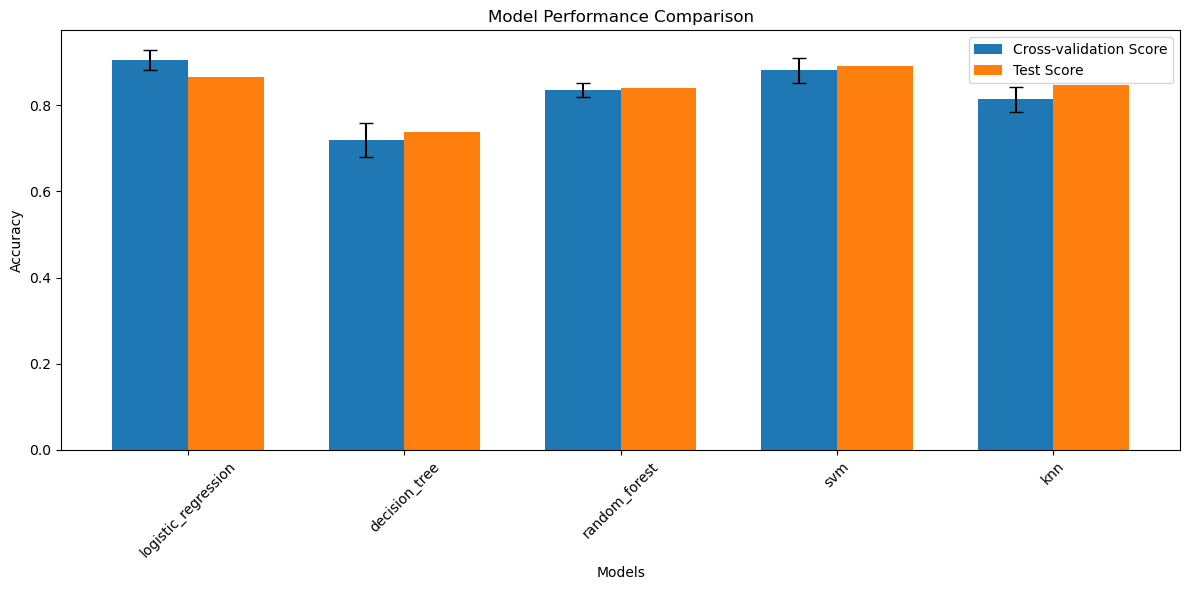

In [176]:
# Initialize pipeline
pipeline = MLPipeline()

# Split your data
X_train, X_test, y_train, y_test = pipeline.split_data(processed_data, y)

# Initial model evaluation
results = pipeline.evaluate_models(X_train, X_test, y_train, y_test)
pipeline.plot_model_comparison(results)




Tuning logistic_regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Tuning decision_tree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Tuning random_forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Tuning svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Tuning knn...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Results for logistic_regression:
Best Parameters: {'C': 1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.8654


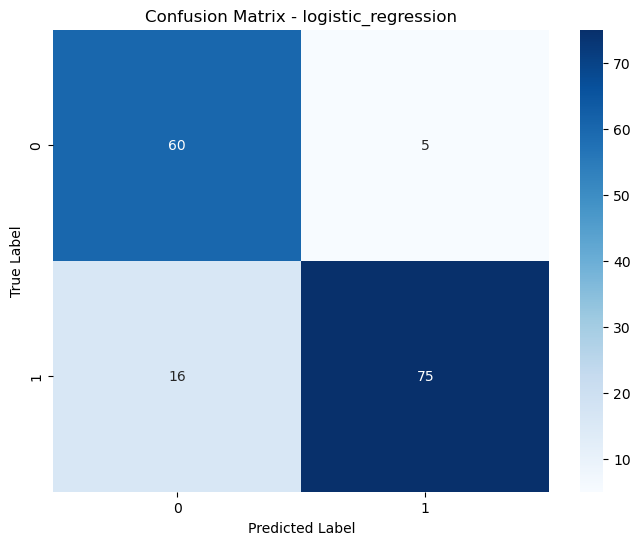


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        65
           1       0.94      0.82      0.88        91

    accuracy                           0.87       156
   macro avg       0.86      0.87      0.86       156
weighted avg       0.88      0.87      0.87       156


Results for decision_tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 10}
Test Accuracy: 0.7756


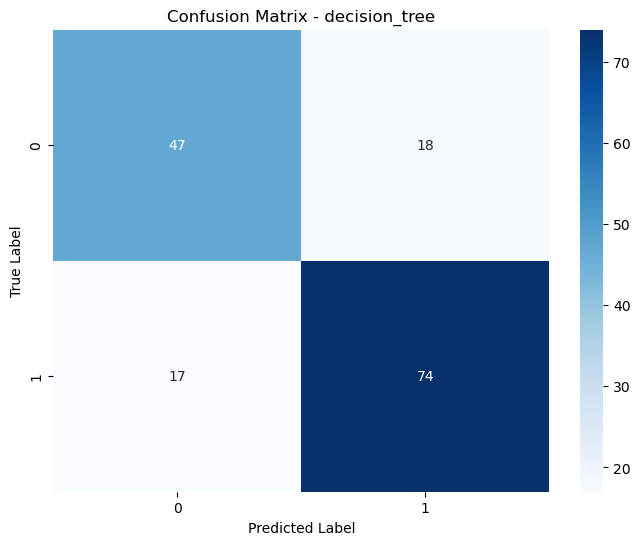


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        65
           1       0.80      0.81      0.81        91

    accuracy                           0.78       156
   macro avg       0.77      0.77      0.77       156
weighted avg       0.78      0.78      0.78       156


Results for random_forest:
Best Parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 300}
Test Accuracy: 0.8462


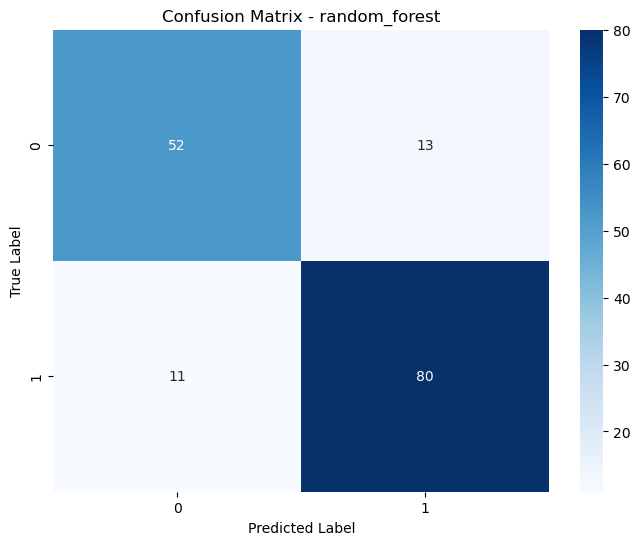


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        65
           1       0.86      0.88      0.87        91

    accuracy                           0.85       156
   macro avg       0.84      0.84      0.84       156
weighted avg       0.85      0.85      0.85       156


Results for svm:
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.8654


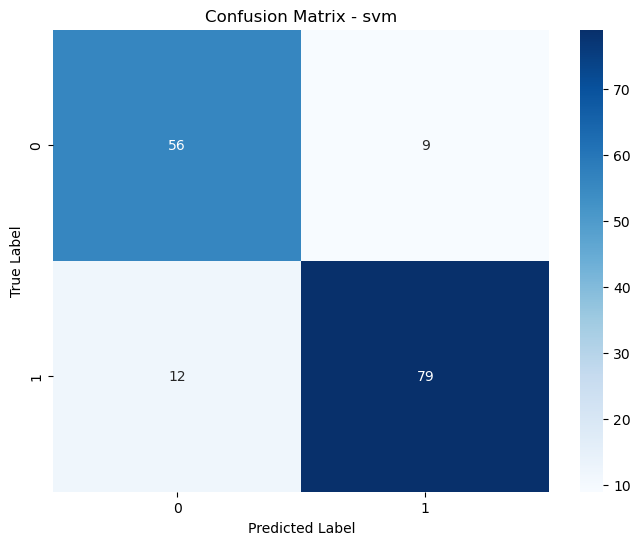


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        65
           1       0.90      0.87      0.88        91

    accuracy                           0.87       156
   macro avg       0.86      0.86      0.86       156
weighted avg       0.87      0.87      0.87       156


Results for knn:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Test Accuracy: 0.8590


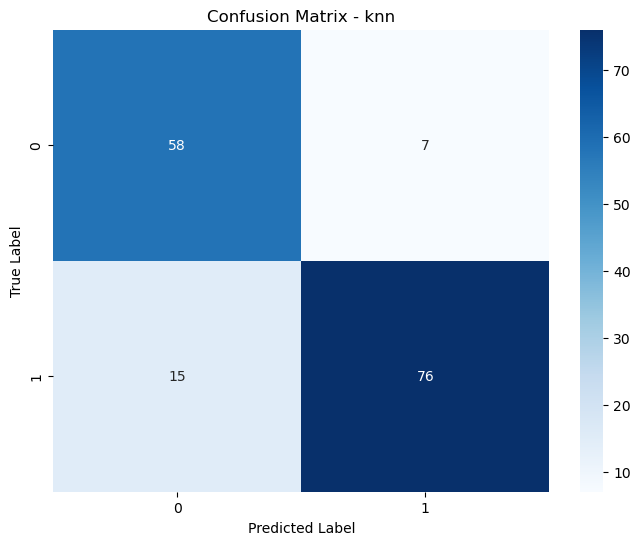


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        65
           1       0.92      0.84      0.87        91

    accuracy                           0.86       156
   macro avg       0.86      0.86      0.86       156
weighted avg       0.87      0.86      0.86       156



In [177]:
# Tune hyperparameters
tuned_models = pipeline.tune_hyperparameters(X_train, y_train)

# Evaluate best models
final_results = pipeline.evaluate_best_model(X_test, y_test)

# Documentación de las Pruebas Unitarias para `DataPreprocessor`

Este notebook contiene una serie de pruebas unitarias para verificar el correcto funcionamiento de la clase `DataPreprocessor`, que realiza el preprocesamiento de datos, incluyendo normalización, codificación de variables categóricas y reducción de dimensionalidad. A continuación, se describen las pruebas realizadas:

### 1. `test_initialization`
Verifica que la inicialización de `DataPreprocessor` configure correctamente los atributos predeterminados, como el método de normalización, el método de codificación categórica, la opción de reducción de dimensiones y el número de componentes de PCA.

### 2. `test_initialization_custom`
Comprueba que la clase `DataPreprocessor` se inicialice correctamente cuando se le pasan parámetros personalizados. Asegura que cada parámetro esté correctamente asignado.

### 3. `test_identify_column_types`
Esta prueba verifica que `identify_column_types` identifique correctamente las columnas numéricas y categóricas en el conjunto de datos de prueba. Compara las columnas identificadas con las esperadas.

### 4. `test_create_preprocessors`
Evalúa la correcta creación de los preprocesadores según la configuración especificada. En particular, verifica que:
   - Se instancie el `StandardScaler` (para normalización estándar).
   - Se añada un `OneHotEncoder` en `categorical_transformers` cuando se selecciona la codificación `onehot`.
   - O, alternativamente, que se cree un `LabelEncoder` para cada columna categórica cuando se utiliza el método `label`.

### 5. `test_fit_transform_without_pca`
Prueba el método `fit_transform` en modo de transformación completa sin aplicar PCA. Verifica que el DataFrame de salida tenga el mismo número de filas que el de entrada y que no contenga valores NaN. También asegura que el número de columnas aumente debido a la codificación de variables categóricas.

### 6. `test_fit_transform_with_pca`
Evalúa el método `fit_transform` cuando se especifica la reducción de dimensiones (PCA) con `n_components=2`. Verifica que el número de columnas en el DataFrame de salida sea igual a la cantidad de componentes solicitada.

### 7. `test_handle_empty_categorical`
Comprueba el correcto funcionamiento de `fit_transform` cuando el conjunto de datos no contiene columnas categóricas. Verifica que el método pueda manejar este caso sin errores.

### 8. `test_handle_empty_numerical`
Prueba el manejo de datos sin columnas numéricas en el método `fit_transform`. Verifica que el procesamiento de datos categóricos sea exitoso en ausencia de datos numéricos.

### 9. Prueba de Integración `test_end_to_end_workflow`
Esta prueba de integración evalúa el flujo completo de preprocesamiento en un conjunto de datos más grande y complejo, con una variedad de configuraciones (sin reducción de dimensiones, con normalización `minmax`, con reducción de dimensiones `PCA`). Verifica que el preprocesador maneje correctamente valores faltantes y que los resultados cumplan con las expectativas en cuanto a forma y calidad de datos.

### Ejecución de las Pruebas
Las pruebas se ejecutan juntas utilizando `unittest.TextTestRunner(verbosity=2)`. Esto permite visualizar un reporte detallado sobre el éxito o falla de cada prueba, facilitando la identificación de problemas en la implementación de `DataPreprocessor`.

Estas pruebas aseguran la robustez de la clase `DataPreprocessor` y su capacidad para manejar diferentes tipos de datos y configuraciones.


In [178]:
#Creamos una clase de pruebas heredando de unittest.TestCase
class TestDataPreprocessor(unittest.TestCase):
    
    def setUp(self):
        """Se ejecuta antes de cada prueba"""
        # Datos de prueba
        self.sample_data = pd.DataFrame({
            'num1': [1, 2, np.nan, 4],
            'num2': [1.1, 2.2, 3.3, 4.4],
            'cat1': ['A', 'B', None, 'A'],
            'cat2': ['X', 'Y', 'Z', 'X']
        })
        
        # Instancia básica del preprocessor
        self.preprocessor = DataPreprocessor()
        
    def test_initialization(self):
        """Prueba la inicialización con parámetros por defecto"""
        processor = DataPreprocessor()
        self.assertEqual(processor.normalization_method, 'standard')
        self.assertEqual(processor.categorical_method, 'onehot')
        self.assertTrue(processor.reduce_dimensions)
        self.assertIsNone(processor.n_components)
        self.assertEqual(processor.random_state, 42)
        print("✅ Prueba de inicialización completada")

    def test_initialization_custom(self):
        """Prueba la inicialización con parámetros personalizados"""
        processor = DataPreprocessor(
            normalization_method='minmax',
            categorical_method='label',
            reduce_dimensions=False,
            n_components=2,
            random_state=123
        )
        self.assertEqual(processor.normalization_method, 'minmax')
        self.assertEqual(processor.categorical_method, 'label')
        self.assertFalse(processor.reduce_dimensions)
        self.assertEqual(processor.n_components, 2)
        self.assertEqual(processor.random_state, 123)
        print("✅ Prueba de inicialización personalizada completada")

    def test_identify_column_types(self):
        """Prueba la identificación correcta de tipos de columnas"""
        self.preprocessor.identify_column_types(self.sample_data)
        self.assertEqual(list(self.preprocessor.numerical_columns), ['num1', 'num2'])
        self.assertEqual(list(self.preprocessor.categorical_columns), ['cat1', 'cat2'])
        print("✅ Prueba de identificación de columnas completada")

    def test_create_preprocessors(self):
        """Prueba la creación de preprocessors con configuración estándar"""
        self.preprocessor = DataPreprocessor(categorical_method='onehot')
        self.preprocessor.create_preprocessors()

        self.assertIsInstance(
            self.preprocessor.numerical_transformer.named_steps['scaler'], 
            StandardScaler
        )

        # Check for OneHotEncoder if the categorical method is 'onehot'
        if self.preprocessor.categorical_method == 'onehot':
            self.assertIn('onehot', self.preprocessor.categorical_transformers)
            self.assertIsInstance(
                self.preprocessor.categorical_transformers['onehot'], 
                OneHotEncoder
            )

        print("✅ Prueba de creación de preprocessors completada")

    def test_fit_transform_without_pca(self):
        """Prueba la transformación completa sin reducción de dimensiones"""
        processor = DataPreprocessor(reduce_dimensions=False)
        transformed_data = processor.fit_transform(self.sample_data)
        
        self.assertEqual(transformed_data.shape[0], self.sample_data.shape[0])
        self.assertFalse(np.isnan(transformed_data.values).any())
        self.assertGreater(len(transformed_data.columns), len(self.sample_data.columns))
        print("✅ Prueba de transformación sin PCA completada")

    def test_fit_transform_with_pca(self):
        """Prueba la transformación completa con PCA"""
        processor = DataPreprocessor(reduce_dimensions=True, n_components=2)
        transformed_data = processor.fit_transform(self.sample_data)
        
        self.assertEqual(transformed_data.shape[1], 2)
        self.assertEqual(list(transformed_data.columns), ['PC1', 'PC2'])
        print("✅ Prueba de transformación con PCA completada")

    def test_handle_empty_categorical(self):
        """Prueba el manejo de datos sin columnas categóricas"""
        data = pd.DataFrame({
            'num1': [1, 2, 3],
            'num2': [4, 5, 6]
        })
        processor = DataPreprocessor(reduce_dimensions=False)
        transformed_data = processor.fit_transform(data)
        self.assertEqual(transformed_data.shape[1], 2)
        print("✅ Prueba de manejo de datos sin categorías completada")

    def test_handle_empty_numerical(self):
        """Prueba el manejo de datos sin columnas numéricas"""
        data = pd.DataFrame({
            'cat1': ['A', 'B', 'C'],
            'cat2': ['X', 'Y', 'Z']
        })
        processor = DataPreprocessor(reduce_dimensions=False)
        transformed_data = processor.fit_transform(data)
        self.assertEqual(transformed_data.shape[0], 3)
        print("✅ Prueba de manejo de datos sin numéricos completada")

# Prueba de integración
class TestDataPreprocessorIntegration(unittest.TestCase):
    
    def test_end_to_end_workflow(self):
        """Prueba de integración del flujo completo de preprocesamiento"""
        # Crear datos más complejos para prueba
        np.random.seed(42)
        n_samples = 100
        data = pd.DataFrame({
            'numerical1': np.random.normal(0, 1, n_samples),
            'numerical2': np.random.uniform(-1, 1, n_samples),
            'categorical1': np.random.choice(['A', 'B', 'C'], n_samples),
            'categorical2': np.random.choice(['X', 'Y'], n_samples)
        })
        
        # Introducir algunos valores faltantes
        data.loc[np.random.choice(n_samples, 10), 'numerical1'] = np.nan
        data.loc[np.random.choice(n_samples, 10), 'categorical1'] = None
        
        # Procesar datos con diferentes configuraciones
        processors = [
            DataPreprocessor(reduce_dimensions=False),
            DataPreprocessor(normalization_method='minmax', categorical_method='label'),
            DataPreprocessor(reduce_dimensions=True, n_components=2)
        ]
        
        for i, processor in enumerate(processors):
            transformed_data = processor.fit_transform(data)
            
            self.assertEqual(transformed_data.shape[0], n_samples)
            self.assertFalse(np.isnan(transformed_data.values).any())
            
            if processor.reduce_dimensions:
                self.assertEqual(transformed_data.shape[1], processor.n_components)
            else:
                self.assertGreaterEqual(transformed_data.shape[1], data.shape[1])
            
            print(f"✅ Prueba de integración {i+1}/3 completada")

# Documentación de las Pruebas Unitarias para `MLPipeline`

Este conjunto de pruebas unitarias está diseñado para verificar la funcionalidad de la clase `MLPipeline`, que gestiona el flujo de entrenamiento, evaluación y ajuste de modelos de aprendizaje automático. A continuación, se describen las pruebas implementadas:

### 1. `test_initialization`
Verifica que la inicialización de `MLPipeline` establezca correctamente los parámetros iniciales:
   - Comprueba que `random_state` sea el valor especificado.
   - Asegura que el diccionario `models` contenga cinco modelos predeterminados: `logistic_regression`, `decision_tree`, `random_forest`, `svm` y `knn`.

### 2. `test_split_data`
Prueba la función de división de datos (`split_data`), que separa el conjunto de datos en entrenamiento y prueba (con una proporción predeterminada de 0.2):
   - Comprueba que el tamaño de los conjuntos de entrenamiento y prueba sea correcto.
   - Verifica que la proporción de la división esté cerca del valor esperado (0.2).

### 3. `test_evaluate_models`
Evalúa la función `evaluate_models`, que entrena y evalúa cada modelo en el conjunto de datos de prueba:
   - Asegura que cada modelo sea evaluado y que los resultados contengan métricas clave (`cv_mean`, `cv_std`, y `test_accuracy`).
   - Verifica que los valores de las métricas estén dentro del rango esperado [0, 1].

### 4. `test_tune_hyperparameters`
Prueba el ajuste de hiperparámetros con `tune_hyperparameters`, que utiliza búsqueda de hiperparámetros para mejorar el rendimiento de cada modelo:
   - Para agilizar la prueba, solo se ajusta el modelo `decision_tree`.
   - Verifica que la salida contenga `best_params`, `best_score`, y `best_model` para cada modelo ajustado.
   - Comprueba que el mejor score (`best_score`) esté en el rango [0, 1].

### 5. `test_evaluate_best_model`
Prueba la evaluación del mejor modelo utilizando `evaluate_best_model`, que evalúa el rendimiento de los modelos ajustados en el conjunto de datos de prueba:
   - Solo se utiliza el modelo `decision_tree` para esta prueba.
   - Asegura que los resultados incluyen `accuracy` y `best_params`.
   - Verifica que la `accuracy` esté dentro del rango [0, 1].

### Prueba de Integración: `test_full_pipeline_workflow`
Esta prueba evalúa el flujo completo de `MLPipeline`, desde la división de datos hasta la evaluación de los mejores modelos:
   - Utiliza un conjunto de datos sintético más complejo y evalúa solo dos modelos (`logistic_regression


In [179]:
class TestMLPipeline(unittest.TestCase):
    
    def setUp(self):
        """Se ejecuta antes de cada prueba"""
        # Crear datos sintéticos para pruebas
        np.random.seed(42)
        n_samples = 100
        self.X = pd.DataFrame({
            'feature1': np.random.normal(0, 1, n_samples),
            'feature2': np.random.normal(0, 1, n_samples)
        })
        self.y = np.random.choice([0, 1], n_samples)
        
        # Instancia de MLPipeline
        self.pipeline = MLPipeline(random_state=42)
        
    def test_initialization(self):
        """Prueba la inicialización de MLPipeline"""
        self.assertEqual(self.pipeline.random_state, 42)
        self.assertIsInstance(self.pipeline.models, dict)
        self.assertEqual(len(self.pipeline.models), 5)  # 5 modelos diferentes
        self.assertIn('logistic_regression', self.pipeline.models)
        self.assertIn('decision_tree', self.pipeline.models)
        self.assertIn('random_forest', self.pipeline.models)
        self.assertIn('svm', self.pipeline.models)
        self.assertIn('knn', self.pipeline.models)
        print("✅ Prueba de inicialización completada")

    def test_split_data(self):
        """Prueba la división de datos"""
        X_train, X_test, y_train, y_test = self.pipeline.split_data(self.X, self.y)
        
        # Verificar las dimensiones
        self.assertEqual(len(X_train) + len(X_test), len(self.X))
        self.assertEqual(len(y_train) + len(y_test), len(self.y))
        
        # Verificar la proporción del split (por defecto 0.2)
        self.assertAlmostEqual(len(X_test) / len(self.X), 0.2, delta=0.01)
        print("✅ Prueba de división de datos completada")

    def test_evaluate_models(self):
        """Prueba la evaluación de modelos"""
        X_train, X_test, y_train, y_test = self.pipeline.split_data(self.X, self.y)
        results = self.pipeline.evaluate_models(X_train, X_test, y_train, y_test)
        
        # Verificar que todos los modelos fueron evaluados
        self.assertEqual(len(results), len(self.pipeline.models))
        
        # Verificar la estructura de los resultados
        for model_name in self.pipeline.models.keys():
            self.assertIn(model_name, results)
            self.assertIn('cv_mean', results[model_name])
            self.assertIn('cv_std', results[model_name])
            self.assertIn('test_accuracy', results[model_name])
            
            # Verificar que los scores están en el rango [0, 1]
            self.assertGreaterEqual(results[model_name]['cv_mean'], 0)
            self.assertLessEqual(results[model_name]['cv_mean'], 1)
            self.assertGreaterEqual(results[model_name]['test_accuracy'], 0)
            self.assertLessEqual(results[model_name]['test_accuracy'], 1)
        print("✅ Prueba de evaluación de modelos completada")

    def test_tune_hyperparameters(self):
        """Prueba la búsqueda de hiperparámetros"""
        X_train, X_test, y_train, y_test = self.pipeline.split_data(self.X, self.y)
        
        # Usar solo un modelo para la prueba para que sea más rápida
        self.pipeline.models = {
            'decision_tree': self.pipeline.models['decision_tree']
        }
        
        tuned_models = self.pipeline.tune_hyperparameters(X_train, y_train, cv=2)
        
        # Verificar la estructura de los resultados
        self.assertIn('decision_tree', tuned_models)
        self.assertIn('best_params', tuned_models['decision_tree'])
        self.assertIn('best_score', tuned_models['decision_tree'])
        self.assertIn('best_model', tuned_models['decision_tree'])
        
        # Verificar que el mejor score está en el rango [0, 1]
        self.assertGreaterEqual(tuned_models['decision_tree']['best_score'], 0)
        self.assertLessEqual(tuned_models['decision_tree']['best_score'], 1)
        print("✅ Prueba de búsqueda de hiperparámetros completada")

    def test_evaluate_best_model(self):
        """Prueba la evaluación del mejor modelo"""
        X_train, X_test, y_train, y_test = self.pipeline.split_data(self.X, self.y)
        
        # Usar solo un modelo para la prueba
        self.pipeline.models = {
            'decision_tree': self.pipeline.models['decision_tree']
        }
        
        # Entrenar y ajustar el modelo
        self.pipeline.tune_hyperparameters(X_train, y_train, cv=2)
        results = self.pipeline.evaluate_best_model(X_test, y_test)
        
        # Verificar la estructura de los resultados
        self.assertIn('decision_tree', results)
        self.assertIn('accuracy', results['decision_tree'])
        self.assertIn('best_params', results['decision_tree'])
        
        # Verificar que la accuracy está en el rango [0, 1]
        self.assertGreaterEqual(results['decision_tree']['accuracy'], 0)
        self.assertLessEqual(results['decision_tree']['accuracy'], 1)
        print("✅ Prueba de evaluación del mejor modelo completada")

# Prueba de integración para MLPipeline
class TestMLPipelineIntegration(unittest.TestCase):
    
    def test_full_pipeline_workflow(self):
        """Prueba el flujo completo del pipeline"""
        # Crear datos sintéticos más complejos
        np.random.seed(42)
        n_samples = 200
        X = pd.DataFrame({
            'feature1': np.random.normal(0, 1, n_samples),
            'feature2': np.random.normal(0, 1, n_samples),
            'feature3': np.random.normal(0, 1, n_samples)
        })
        y = (X['feature1'] + X['feature2'] > 0).astype(int)
        
        # Crear pipeline con menos modelos para que la prueba sea más rápida
        pipeline = MLPipeline(random_state=42)
        pipeline.models = {
            'logistic_regression': pipeline.models['logistic_regression'],
            'decision_tree': pipeline.models['decision_tree']
        }
        
        # Ejecutar el flujo completo
        X_train, X_test, y_train, y_test = pipeline.split_data(X, y)
        
        # Evaluar modelos iniciales
        initial_results = pipeline.evaluate_models(X_train, X_test, y_train, y_test)
        self.assertGreaterEqual(len(initial_results), 1)
        
        # Ajustar hiperparámetros
        tuned_results = pipeline.tune_hyperparameters(X_train, y_train, cv=2)
        self.assertGreaterEqual(len(tuned_results), 1)
        
        # Evaluar mejores modelos
        final_results = pipeline.evaluate_best_model(X_test, y_test)
        self.assertGreaterEqual(len(final_results), 1)
        
        print("✅ Prueba de integración del pipeline completo completada")

## Funcion que nos permite correr todas las pruebas de integracion y unitarias

In [184]:
def run_all_tests():
    # Crear un test loader
    loader = unittest.TestLoader()
    
    # Crear una suite con todas las pruebas
    suite = unittest.TestSuite()
    
    # Agregar todas las clases de prueba
    suite.addTests(loader.loadTestsFromTestCase(TestDataPreprocessor))
    suite.addTests(loader.loadTestsFromTestCase(TestDataPreprocessorIntegration))
    suite.addTests(loader.loadTestsFromTestCase(TestMLPipeline))
    suite.addTests(loader.loadTestsFromTestCase(TestMLPipelineIntegration))
    
    # Crear un runner que mostrará los resultados
    runner = unittest.TextTestRunner(verbosity=2)
    
    # Ejecutar las pruebas
    runner.run(suite)

test_create_preprocessors (__main__.TestDataPreprocessor)
Prueba la creación de preprocessors con configuración estándar ... ok
test_fit_transform_with_pca (__main__.TestDataPreprocessor)
Prueba la transformación completa con PCA ... 

✅ Prueba de creación de preprocessors completada
Numerical columns: ['num1', 'num2']
Categorical columns: ['cat1', 'cat2']


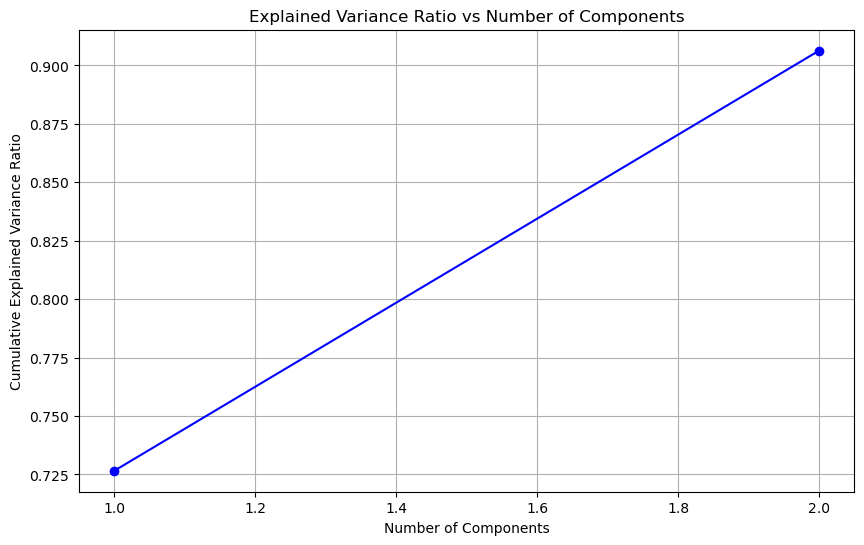

ok
test_fit_transform_without_pca (__main__.TestDataPreprocessor)
Prueba la transformación completa sin reducción de dimensiones ... ok
test_handle_empty_categorical (__main__.TestDataPreprocessor)
Prueba el manejo de datos sin columnas categóricas ... ok
test_handle_empty_numerical (__main__.TestDataPreprocessor)
Prueba el manejo de datos sin columnas numéricas ... ok
test_identify_column_types (__main__.TestDataPreprocessor)
Prueba la identificación correcta de tipos de columnas ... ok
test_initialization (__main__.TestDataPreprocessor)
Prueba la inicialización con parámetros por defecto ... ok
test_initialization_custom (__main__.TestDataPreprocessor)
Prueba la inicialización con parámetros personalizados ... ok
test_end_to_end_workflow (__main__.TestDataPreprocessorIntegration)
Prueba de integración del flujo completo de preprocesamiento ... 


Explained variance ratio by component:
PC1: 0.7266
PC2: 0.1797
✅ Prueba de transformación con PCA completada
Numerical columns: ['num1', 'num2']
Categorical columns: ['cat1', 'cat2']
✅ Prueba de transformación sin PCA completada
Numerical columns: ['num1', 'num2']
Categorical columns: []
✅ Prueba de manejo de datos sin categorías completada
Numerical columns: []
Categorical columns: ['cat1', 'cat2']
✅ Prueba de manejo de datos sin numéricos completada
Numerical columns: ['num1', 'num2']
Categorical columns: ['cat1', 'cat2']
✅ Prueba de identificación de columnas completada
✅ Prueba de inicialización completada
✅ Prueba de inicialización personalizada completada
Numerical columns: ['numerical1', 'numerical2']
Categorical columns: ['categorical1', 'categorical2']
✅ Prueba de integración 1/3 completada
Numerical columns: ['numerical1', 'numerical2']
Categorical columns: ['categorical1', 'categorical2']


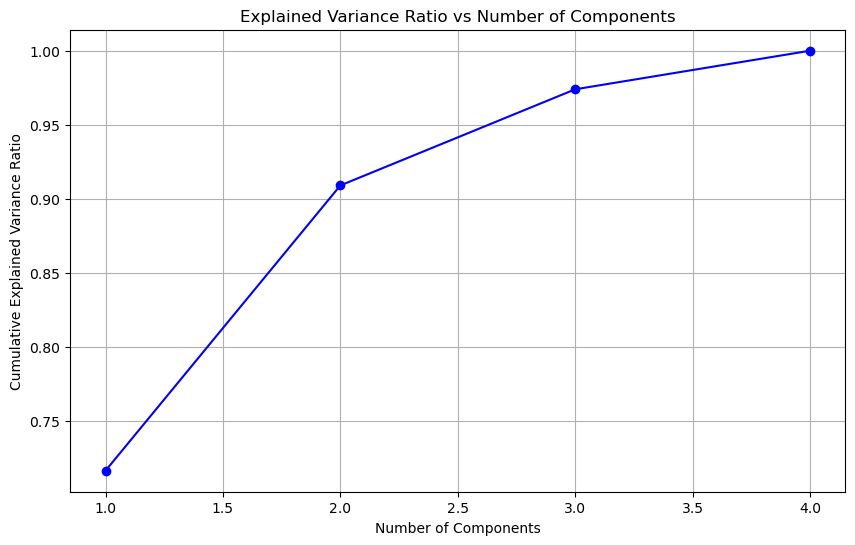


Explained variance ratio by component:
PC1: 0.7161
PC2: 0.1928
PC3: 0.0650
PC4: 0.0261
✅ Prueba de integración 2/3 completada
Numerical columns: ['numerical1', 'numerical2']
Categorical columns: ['categorical1', 'categorical2']


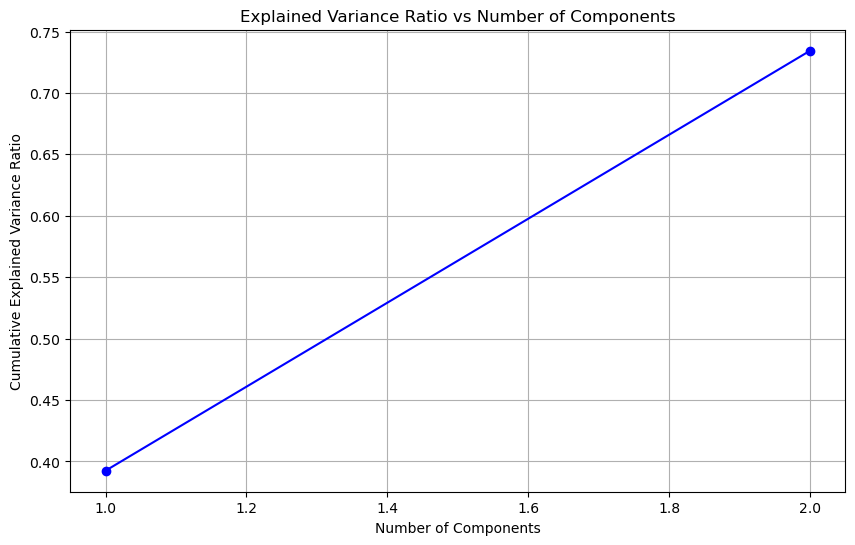

ok
test_evaluate_best_model (__main__.TestMLPipeline)
Prueba la evaluación del mejor modelo ... 


Explained variance ratio by component:
PC1: 0.3925
PC2: 0.3419
✅ Prueba de integración 3/3 completada

Tuning decision_tree...
Fitting 2 folds for each of 24 candidates, totalling 48 fits

Results for decision_tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}
Test Accuracy: 0.6000


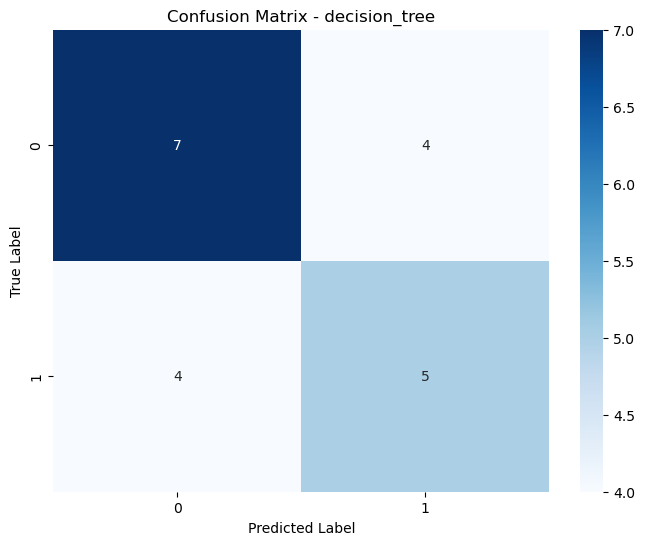

ok
test_evaluate_models (__main__.TestMLPipeline)
Prueba la evaluación de modelos ... 


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20

✅ Prueba de evaluación del mejor modelo completada


ok
test_initialization (__main__.TestMLPipeline)
Prueba la inicialización de MLPipeline ... ok
test_split_data (__main__.TestMLPipeline)
Prueba la división de datos ... ok
test_tune_hyperparameters (__main__.TestMLPipeline)
Prueba la búsqueda de hiperparámetros ... ok
test_full_pipeline_workflow (__main__.TestMLPipelineIntegration)
Prueba el flujo completo del pipeline ... 

✅ Prueba de evaluación de modelos completada
✅ Prueba de inicialización completada
✅ Prueba de división de datos completada

Tuning decision_tree...
Fitting 2 folds for each of 24 candidates, totalling 48 fits
✅ Prueba de búsqueda de hiperparámetros completada

Tuning logistic_regression...
Fitting 2 folds for each of 24 candidates, totalling 48 fits

Tuning decision_tree...
Fitting 2 folds for each of 24 candidates, totalling 48 fits

Results for logistic_regression:
Best Parameters: {'C': 1, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.9250


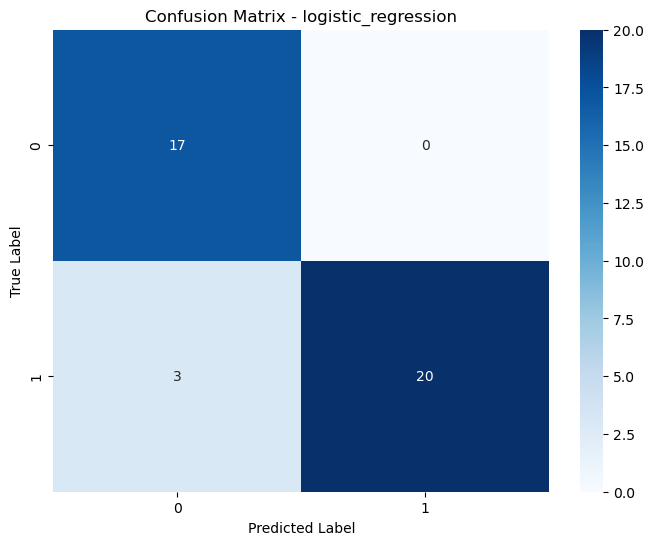


Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      0.87      0.93        23

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.94      0.93      0.93        40


Results for decision_tree:
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Test Accuracy: 0.9000


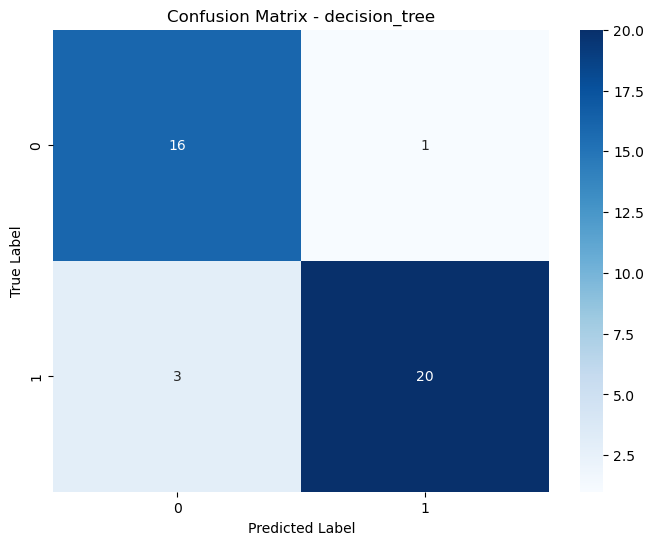

ok

----------------------------------------------------------------------
Ran 15 tests in 1.043s

OK



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.95      0.87      0.91        23

    accuracy                           0.90        40
   macro avg       0.90      0.91      0.90        40
weighted avg       0.91      0.90      0.90        40

✅ Prueba de integración del pipeline completo completada


In [185]:
run_all_tests()

In [58]:
def export_model(model):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    path = os.path.join(parent_directory,'models/appendictis_model.pkl')
    joblib.dump(model,path)

    print("Data stored at:", path)
    return None